# Imports

In [12]:
# standard packages
import os
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

# internal imports
from deepSNIaID import deepSNIaID
from deepSNIaID import utils
from deepSNIaID.preprocessing import Spectrum

In [26]:
# set style
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['xtick.minor.visible'] = True
rcParams['xtick.minor.size'] = 4
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.pad'] = 10
rcParams['ytick.minor.visible'] = True
rcParams['ytick.minor.size'] = 4
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.pad'] = 10
rcParams['axes.grid'] = False
rcParams['xtick.direction'] = 'in'
rcParams['xtick.top'] = True
rcParams['ytick.direction'] = 'in'
rcParams['ytick.right'] = True

# Set Global Variables

In [29]:
# spectrum
SPEC_FILE = os.path.join('spectra', 'sn2016coj-20160610.245-ui.flm')
REDSHIFT = 0.004483
SPEC = Spectrum(SPEC_FILE, REDSHIFT, obsframe = True)

# Make Sample Preprocessing Plot from Paper

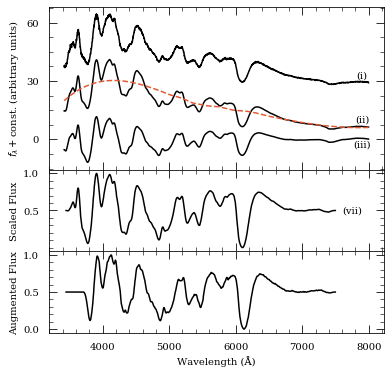

In [30]:
# instantiate plot, create axes, and format
fig = plt.figure(figsize = (6, 6))
gs = gridspec.GridSpec(3, 1, height_ratios = (2, 1, 1), hspace = 0)
ax = plt.subplot(gs[0])
_ = plt.setp(ax.get_xticklabels(), visible = False)
ax.set_ylabel('$f_\lambda + $const. (arbitrary units)', labelpad = 5)
ax.set_yticks([0, 30, 60])
ax2 = plt.subplot(gs[1], sharex = ax)
ax2.set_ylabel('Scaled Flux')
ax2.set_yticks([0.5, 1])
ax3 = plt.subplot(gs[2], sharex = ax)
ax3.set_ylabel('Augmented Flux')
ax3.set_yticks([0., 0.5, 1])
ax3.set_xlabel('Wavelength (\u212B)')

### do processing "manually" using utilities, to isolate the effect of individual effects
wave, flux = SPEC.wave, SPEC.flux

# plot deredshifted but otherwise "raw" spectrum
ax.plot(wave, flux + 25, color = 'black')
ax.text(7900, 33, '(i)', ha = 'center', va = 'center')

# plot smoothed spectrum (steps from _process method)
angstroms_per_pixel = np.abs(np.mean(wave[1:] - wave[:-1]))
signal_window_pixels = int(np.ceil( (SPEC.signal_window_angstroms / angstroms_per_pixel) / 2) * 2 - 1)
flux = utils.smooth(flux, signal_window_pixels, SPEC.signal_smoothing_order)
ax.plot(wave, flux + 2, color = 'black')
ax.text(7900, 10, '(ii)', ha = 'center', va = 'center')

# get continuum (steps from _process method)
continuum_window_pixels = int(np.ceil( (SPEC.continuum_window_angstroms / angstroms_per_pixel) / 2) * 2 - 1)
if continuum_window_pixels > len(flux):
    continuum_window_pixels = int(np.ceil( (len(flux) / 1.4) / 2) * 2 - 1)
continuum = utils.get_continuum(flux, continuum_window_pixels, SPEC.continuum_smoothing_order)
norm = matplotlib.colors.Normalize(vmin=0, vmax=40)
ax.plot(wave, continuum + 2, ls = '--', color = matplotlib.colors.rgb2hex(cm.inferno_r(norm(15))[:3]))

# remove continuum
flux -= continuum
ax.plot(wave, flux, color = 'black')
ax.text(7900, -2.5, '(iii)', ha = 'center', va = 'center')

# log bin
wave, flux, valid_mask = utils.log_bin(wave, flux, SPEC.lwave_bounds, SPEC.lwave_n_bins)

# scaling and apodization
flux[valid_mask] = utils.normalize_flux(flux[valid_mask])
flux[valid_mask] = utils.apodize(flux[valid_mask], SPEC.apodize_end_pct)

# offset
flux += 0.5

# final spectrum
ax2.plot(wave, flux, color = 'black')
ax2.text(7750, 0.5, '(vii)', ha = 'center', va = 'center')

### check consistency between "manual" preprocessing and automated processing
_flux = SPEC.process()
assert (_flux == flux).all()

# augment and plot
ax3.plot(wave,  SPEC.augprocess(0.004, 50), color = 'black')

plt.savefig('../../figures/preprocessing.pdf', bbox_inches = 'tight')

In [5]:
np.save('../../notebooks/wave.npy', wave)
np.save('../../notebooks/flux.npy', flux)

# Run Models on Test Sets

In [2]:
dsn = deepSNIaID()

No GPU available. Using CPU instead...


In [3]:
X1 = np.load('testing_sets/Domain.X.npy')

In [9]:
r = dsn.predict(X1, mcnum = 20)

In [10]:
r.loc[r['Domain'] == 0, :].describe()

,Domain,Phase,e_Phase,dm15,e_dm15
count,95.0,95.000000,95.000000,95.000000,95.000000
mean,0.0,17.798380,6.900515,1.164314,0.108058
std,0.0,11.875820,2.493023,0.210240,0.046836
min,0.0,-9.412978,1.536816,0.778072,0.059932
25%,0.0,15.134690,6.100241,1.030134,0.075483
50%,0.0,23.281982,8.039431,1.089821,0.089552
75%,0.0,26.558853,8.838254,1.227709,0.121013
max,0.0,29.199650,9.585867,1.720239,0.234922


In [11]:
r.loc[r['Domain'] == 1, :].describe()

,Domain,Phase,e_Phase,dm15,e_dm15
count,193.0,193.000000,193.000000,193.000000,193.000000
mean,1.0,7.122574,4.295037,1.183854,0.111359
std,0.0,9.704094,2.104213,0.231973,0.050474
min,1.0,-9.268703,1.401869,0.789662,0.043117
25%,1.0,-0.613776,2.525721,1.001388,0.070277
50%,1.0,5.770147,3.779378,1.119795,0.098184
75%,1.0,13.857515,5.706716,1.347661,0.144980
max,1.0,26.823639,8.955725,1.708323,0.233296


In [ ]:
pd.DataFrame()